In [1]:
from numpy import asarray
from skimage import data, io, color, filters, feature, transform
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

%matplotlib qt

# Q1

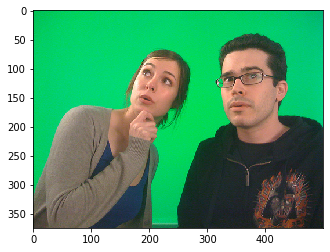

In [5]:
actors = io.imread("../assets/assignment-1/greenscreen.jpg")
plt.imshow(actors)

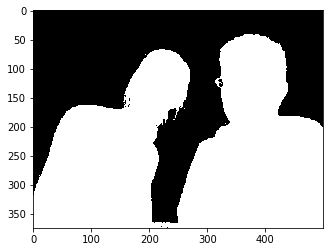

In [11]:
def threshold_func(image):
    r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
    return np.array(np.logical_or(r >= 10, g <= 100, b <= 50), dtype="uint8") # DeMorgan's law : A and B and C = not A or not B or not C
outline = threshold_func(actors)
plt.imshow(outline, cmap=plt.cm.gray)

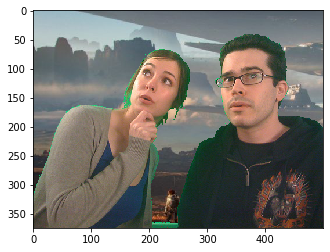

In [14]:
background = io.imread("../assets/assignment-1/background.jpg")
output = np.zeros(np.shape(actors), dtype="uint8")
w, h, _ = np.shape(actors)
for i in range(w):
    for k in range(h):
        if outline[i][k]:
            output[i][k] = actors[i][k]
        else:
            output[i][k] = background[i][k]
plt.imshow(output)

# Q2

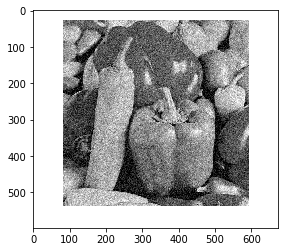

In [15]:
noisy  = io.imread("../assets/assignment-1/noisy.png")
plt.imshow(noisy)

In [5]:
def float2uint8(matrix):
    shape = np.shape(matrix)
    new_matrix = np.zeros(shape, dtype="uint8")
    w, h = shape[0], shape[1]
    for i in range(w):
        for k in range(h):
            new_matrix[i][k] = matrix[i][k]
    return new_matrix

In [6]:
def rgb2grayscale(image):
    w, h, _ = np.shape(image)
    output = np.zeros((w,h), dtype="float")
    for i in range(w):
        for j in range(h):
            r, g, b = image[i][j][0], image[i][j][1], image[i][j][2]
            output[i][j] = 0.2125*r + 0.7154*g + 0.0721*b
    return output.astype(np.uint8)

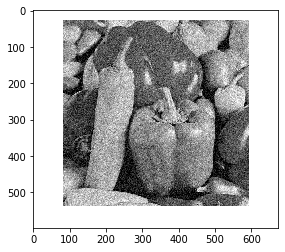

In [18]:
grayscale = rgb2grayscale(noisy)
plt.imshow(grayscale, cmap=plt.cm.gray)

In [19]:
within_bounds = lambda points, bounds: 0 < points[0] < bounds[0] and 0 < points[1] < bounds[1]

In [20]:
def apply_averaging_mask(A, h):
    shapeA = np.shape(A)
    M = 1/h**2 * np.ones((h, h), dtype="float")
    output = np.zeros(shapeA, dtype="float")
    row_m, col_m = np.shape(M)
    row_a, col_a, = shapeA[0], shapeA[1]
    for r in range(row_a):
        for c in range(col_a):
            val = 0.0
            for i in range(-h, h+1):
                for j in range(-h, h+1):
                    if within_bounds((i+h+1, j+h+1), (row_m, col_m)) and within_bounds((r+i, c+j), (row_a, col_a)):
                        val += M[i+h+1][j+h+1] * A[r+i][c+j]
            output[r][c] = val
    return output.astype(np.uint8)

def apply_median_filter(A, h):
    shapeA = np.shape(A)
    M = np.zeros(h*h, dtype="float")
    output = np.zeros(shapeA, dtype="float")
    row_m, col_m = h, h
    row_a, col_a, = shapeA[0], shapeA[1]
    hrow_m, hcol_m = row_m // 2, col_m //2
    
    for r in range(hrow_m,  row_a - hrow_m):
        for c in range(hcol_m, col_a - hcol_m):
            i = 0
            for fx in range(0, row_m):
                for fy in range(0, col_m):
                    M[i] = A[r + fx - hrow_m][c + fy - hcol_m]
                    i += 1
            M.sort()
            output[r][c] = M[len(M)//2]
    return output.astype(np.uint8)

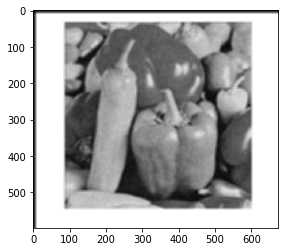

In [21]:
h = 10
avg_filter = apply_averaging_mask(grayscale , h)
plt.imshow(avg_filter, cmap=plt.cm.gray)

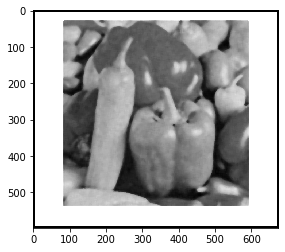

In [22]:
h = 10
median_filter = apply_median_filter(grayscale , h)
plt.imshow(median_filter, cmap=plt.cm.gray)

In [29]:
unsharp_filter = np.zeros(np.shape(avg_filter), dtype="float")
r, c = np.shape(avg_filter)
min_val, max_val = 0, 0
for i in range(r):
    for j in range(c):
        unsharp_filter[i][j] = 2 * grayscale[i][j] - avg_filter[i][j] 
        if min_val > unsharp_filter[i][j]:
            min_val = unsharp_filter[i][j]
        if max_val < unsharp_filter[i][j]:
            max_val = unsharp_filter[i][j]

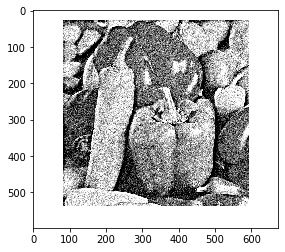

In [30]:
unsharp = float2uint8(np.clip(unsharp_filter, 0, 255))
plt.imshow(unsharp, cmap=plt.cm.gray)

In [35]:
io.imsave("unsharp_mask.jpg", unsharp)

In [25]:
def normalize_intensities(image, min_val, max_val):
    w, h = np.shape(image)
    output = np.zeros((w,h), dtype="float")
    fac = 255 / (max_val - min_val)
    for i in range(w):
        for j in range(h):
            output[i][j] = fac * (image[i][j] - min_val)
    return output.astype(np.uint8)

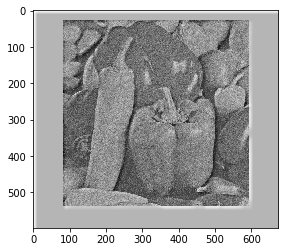

In [26]:
scaled = normalize_intensities(unsharp_filter, min_val, max_val)
plt.imshow(scaled, cmap=plt.cm.gray)

it is better to just ignore or clip the out of range values, because if we scale the intensities back to [0, 255] has the effect of lowering the constrast, undoing the effect of unsharp masking.


# Q3

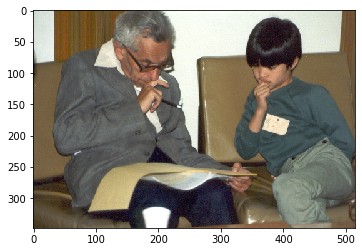

In [19]:
erdos_with_tao = io.imread("../assets/assignment-1/erdos_with_tao.jpg")
plt.imshow(erdos_with_tao, cmap=plt.cm.gray)

In [20]:
def nn_scale_image(image ,s):
    if s == 1.0 : return image
    if s == 0.0 : raise("Cannot scale by zero")
    shape = np.shape(image)
    if len(shape) == 3:
        nr, nc, nd = int(round(s * shape[0]) - 1), int(round(s * shape[1]) - 1), shape[2]
        output = np.zeros((nr, nc, nd), dtype="uint8")
    else:
        nr, nc = int(round(s * shape[0]) - 1), int(round(s * shape[1]) - 1)
        output = np.zeros((nr, nc), dtype="uint8")
    for x in range(nr):
        for y in range(nc):
            nx = int(x//s)
            ny = int(y//s)
            output[x][y] = image[nx][ny]
    return output

In [23]:
def bl_scale_image(image ,s):
    if s == 1.0: return image
    if s == 0.0 : raise("Cannot scale by zero")
    shape = np.shape(image)
    if len(shape) == 3:
        nr, nc, nd = int(round(s * shape[0]) - 1), int(round(s * shape[1]) - 1), shape[2]
        output = np.zeros((nr, nc, nd), dtype="uint8")
    else:
        nr, nc = int(round(s * shape[0]) - 1), int(round(s * shape[1]) - 1)
        output = np.zeros((nr, nc), dtype="uint8")

    for x in range(nr):
        for y in range(nc):
            oldx = x / s
            oldy = y / s
            xf = int(np.floor(oldx))
            xc = xf + 1
            yf = int(np.floor(oldy))
            yc = yf + 1
            
            xf = np.clip(xf, 0, shape[0]-1)
            xc = np.clip(xc, 0, shape[0]-1)
            yf = np.clip(yf, 0, shape[1]-1)
            yc = np.clip(yc, 0, shape[1]-1)
            
            if len(shape) == 3:
                for ch in range(nd):
                    output[x][y][ch] = (yc  - oldy) * ((xc - oldx) * image[xf][yf][ch] + (oldx - xf) * image[xc][yf][ch]) + \
                    (oldy - yf) * ((xc - oldx) * image[xf][yc][ch] + (oldx - xf) * image[xc][yc][ch])
            else:
                output[x][y] = (yc  - oldy) * ((xc - oldx) * image[xf][yf] + (oldx - xf) * image[xc][yf]) + \
                    (oldy - yf) * ((xc - oldx) * image[xf][yc] + (oldx - xf) * image[xc][yc])
    return output.astype(np.uint8)

# Q4

In [2]:
image1 = io.imread("../assets/assignment-1/semper1.jpg")
image2 = io.imread("../assets/assignment-1/semper2.jpg")

#  [1] https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_orb.html
#  [2] http://www.vision.cs.chubu.ac.jp/CV-R/pdf/Rublee_iccv2011.pdf
#  [3] https://ieeexplore.ieee.org/document/6126544
#  [4] https://en.wikipedia.org/wiki/Oriented_FAST_and_rotated_BRIEF

My chosen method was skiimage's ORB module, which combines some technqiues from FAST and BRIEF feature detectors. ORB has been shown to be two orders of magnitude better than SIFT in computational time complexity. Furthermore ORB is rotationally invariant, which is a desirable feature. To getting skimage to perform the two tasks is simple as using the already provided API to detect and extract keypoints and descriptors.

In [7]:
def get_descriptors_and_keypoints(image, n_keypoints):
    feats = feature.ORB(n_keypoints=n_keypoints)
    feats.detect_and_extract(image)
    return feats.keypoints, feats.descriptors

get_matches = lambda descriptors: feature.match_descriptors(descriptors[0], descriptors[1], cross_check=True)

In [8]:
n_keypoints = 300
image1_kp, image1_d = get_descriptors_and_keypoints(rgb2grayscale(image1), n_keypoints)
image2_kp, image2_d = get_descriptors_and_keypoints(rgb2grayscale(image2), n_keypoints)
matches = get_matches((image1_d, image2_d))

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.xticks([])
plt.yticks([])
feature.plot_matches(ax, image1, image2, image1_kp, image2_kp, matches, only_matches=True, matches_color="#fff200", keypoints_color="#000000")
plt.show()

In [13]:
print(image1_kp)

[[156.        539.       ]
 [156.        538.8      ]
 [167.        520.       ]
 [174.        515.       ]
 [174.        514.8      ]
 [273.6       325.44     ]
 [274.        325.       ]
 [164.        545.       ]
 [168.        519.6      ]
 [172.        520.       ]
 [154.08      538.56     ]
 [234.        355.       ]
 [153.792     537.408    ]
 [274.8       325.2      ]
 [180.        512.       ]
 [274.752     326.592    ]
 [380.         60.       ]
 [163.        542.       ]
 [103.2       358.8      ]
 [151.        343.       ]
 [245.        372.       ]
 [164.4       544.8      ]
 [357.         64.       ]
 [108.        149.       ]
 [182.        339.       ]
 [161.        540.       ]
 [113.        139.       ]
 [185.        510.       ]
 [105.6       361.2      ]
 [214.        377.       ]
 [359.         61.       ]
 [115.         59.       ]
 [283.        324.       ]
 [168.48      519.84     ]
 [162.        526.       ]
 [234.        355.2      ]
 [ 99.        362.       ]
 

# Q5

In [47]:
shannon = io.imread("../assets/assignment-1/shannon.jpg")
shannon = rgb2grayscale(shannon)
plt.imshow(shannon, cmap=plt.cm.gray)

In [61]:
scales= np.arange(0.5, 3.6, 0.1)
n_keypoints = 500
invert_coords = lambda x,y,s: (x*s,y*s)
paths = ["../assets/assignment-1/bl_shannon/scaled_shannon_{:.1f}.jpg".format(s) for s in scales]
repeatability = []
accuracy = []

for s, path in zip(scales, paths):
    image = io.imread(path)
    image1_kp, image1_d = get_descriptors_and_keypoints(shannon, n_keypoints)
    image2_kp, image2_d = get_descriptors_and_keypoints(image, n_keypoints)
    matches = get_matches((image1_d, image2_d))
    matched_kp1 = image1_kp[matches[:, 0]]
    matched_kp2 = image2_kp[matches[:, 1]]
    n = len(image1_kp)
    m = len(matched_kp1)
    repeatability_counts = 0
    accuracy_counts = 0
    
    ## repeatibility
    for kp1 in image1_kp:
        x1, y1 = invert_coords(kp1[0], kp1[1], s)
        for kp2 in image2_kp:
            x2, y2 = kp2
            d= np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            if d <= 2:
                repeatability_counts += 1
                break
    ## accuracy
    for kp1 in matched_kp1:
        x1, y1 = invert_coords(kp1[0], kp1[1], s)
        for kp2 in matched_kp2:
            x2, y2 = kp2
            d = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            if d <= 2:
                accuracy_counts += 1
                break
    repeatability.append([s, repeatability_counts / n])
    accuracy.append([s, accuracy_counts / m])

In [62]:
acc = np.array(accuracy)
reap = np.array(repeatability)

In [63]:
fig, ax = plt.subplots()
ax.plot(acc[:, 0], acc[:, 1], '-ro')
plt.show()

In [64]:
fig, ax = plt.subplots()
ax.plot(reap[:, 0], reap[:, 1], '-bo')
plt.show()